In [1]:
import matplotlib.pyplot as plt
import pygpufit.gpufit as gf
import mat73
from os.path import dirname, join as pjoin
from scipy import signal
import numpy as np
# cuda available checks
print('CUDA available: {}'.format(gf.cuda_available()))
print('CUDA versions runtime: {}, driver: {}'.format(*gf.get_cuda_version()))

CUDA available: True
CUDA versions runtime: (11, 4), driver: (12, 1)


In [ ]:
import sys
print(sys.path)

In [2]:
def initialize_parameters(data,center1=None,width1=None,Amp1=None,offset1=1):
    Amp1_array = np.min(data,axis=1)-np.max(data,axis=1)
          
    assert center1 is not None
    assert width1 is not None
    
    center1_array = center1 * np.ones(data.shape[0])
    width1_array = width1 * np.ones(data.shape[0])
    offset1_array = offset1 * np.ones(data.shape[0])
    
    return np.array(np.stack((Amp1_array,center1_array,width1_array,offset1_array),axis=1), dtype=np.float32)

In [3]:
def lorentz_1D(x, p):
    amp = p[0]
    center = p[1]
    width = p[2]
    offset= p[3]
    y = (amp * (width**2))/((x-center)**2 + (width)**2) + offset
    return y 

In [4]:
def gauss_1D(x, p):
    amp = p[0]
    center = p[1]
    width = p[2]
    offset= p[3]
    y = amp * (np.e ** (-(x-center)**2/(2*width**2))) + offset
    return y 

def linear(x, p):
    return p[0] + p[1]*x

In [5]:
data_dir = r"Z:\Montana_setup\samples and data\CrI3_NV\Flake#3_CrI3_twisted_3L+3L_Quinn\Pulsed_ESR\5K\40G_temp_test_v2\RawData"
mat_fname = pjoin(data_dir, "005_ESR.mat")
mat_data = mat73.loadmat(mat_fname)

In [ ]:
mat_data['outputdata'].get('ave').get('mean').shape

In [6]:
raw_data = np.array(mat_data['outputdata']['ave']['mean'])
frequency = np.array(mat_data['outputdata']['freq'], dtype=np.float32)

# Reshape data
data_normalized = raw_data/raw_data[:, :, 1, np.newaxis]

n_fits = raw_data.shape[0]*raw_data.shape[1]
number_points = raw_data.shape[2]
data = np.array(np.reshape(data_normalized, (n_fits, number_points)), dtype=np.float32)

In [ ]:
int(raw_data.shape[-1]/2)

In [7]:
# taking only one lorentzian and every other data point 
raw_data_test = raw_data[:, :, :int(raw_data.shape[-1]/2)-1:2]
frequency_test = frequency[:int(raw_data.shape[-1]/2)-1:2]
data_normalized_test = data_normalized[:, :, :int(raw_data.shape[-1]/2)-1:2]

n_fits_test = raw_data_test.shape[0]*raw_data_test.shape[1]
number_points_test = raw_data_test.shape[2]
data_test = np.array(np.reshape(data_normalized_test, (n_fits_test, number_points_test)), dtype=np.float32)

In [8]:
raw_data_test_upper = raw_data[:, :, int(raw_data.shape[-1]/2)::2]
frequency_test_upper = frequency[int(raw_data.shape[-1]/2)::2]
data_normalized_test_upper = data_normalized[:, :, int(raw_data.shape[-1]/2)::2]

n_fits_test_upper = raw_data_test_upper.shape[0]*raw_data_test_upper.shape[1]
number_points_test_upper = raw_data_test_upper.shape[2]
data_test_upper = np.array(np.reshape(data_normalized_test_upper, (n_fits_test_upper, number_points_test_upper)), dtype=np.float32)

In [ ]:
testing_f1

In [9]:
testing_f1 = np.arange(0,40)

In [10]:
# User Info
user_info = testing_f1

# tolerance
tolerance = 1e-9

# maximum number of iterations
max_number_iterations = 20

# Parameters to Fit
#parameters_to_fit = np.ones(7, dtype=np.float32)

estimator_id = 0

# model ID
# model_id = gf.ModelID.LORENTZ_1D
model_id = gf.ModelID.GAUSS_1D
# Initial parameters
number_fits = 0
initial_parameters = initialize_parameters(data_test,Amp1=None,center1=22,width1=10,offset1=1)
# initial_parameters = np.ones((number_fits, 2), dtype=np.float32)
# initial_parameters = np.array([[15,20,5,1]], dtype=np.float32)
initial_parameters.shape

initial_parameters_upper = initialize_parameters(data_test_upper,Amp1=None,center1=25,width1=10,offset1=1)

In [11]:
# run Gpufit   
parameters, states, chi_squares, number_iterations, execution_time = gf.fit(data_test, None, model_id, initial_parameters, tolerance, max_number_iterations, None, estimator_id, user_info=None)

parameters_upper, states_upper, chi_squares_upper, number_iterations_upper, execution_time_upper = gf.fit(data_test_upper, None, model_id, initial_parameters_upper, tolerance, max_number_iterations, None, estimator_id, user_info=None)

In [ ]:
parameters[3500]

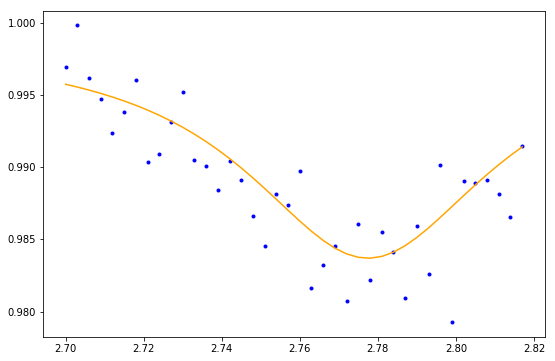

fitted central frequency: 2.783288274765015


In [18]:
# n=0 to n=48399
n=22000

plt.plot(frequency_test,data_test[n,:],'.',c='blue')
plt.plot(frequency_test,lorentz_1D(testing_f1,parameters[n]),c='orange')
plt.show()

fcf = parameters[0][1]*0.003+2.7
print(f'fitted central frequency: {fcf}')

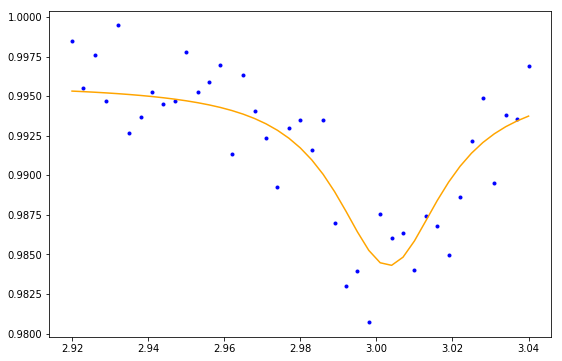

fitted central frequency: 3.007906497955322


In [19]:
# n=0 to n=48399
# n=21000

plt.plot(frequency_test_upper,data_test_upper[n,:],'.',c='blue')
plt.plot(frequency_test_upper,lorentz_1D(testing_f1_upper,parameters_upper[n]),c='orange')
plt.show()

fcf = parameters_upper[0][1]*0.003+2.92
print(f'fitted central frequency: {fcf}')

In [22]:
execution_time

0.32317570003215224

In [23]:
execution_time_upper

0.1972912999917753

In [24]:
ratio = np.sum(states == 1) / parameters.shape[0] * 100
print(f'ratio max iterations exceeded  {ratio} %')

ratio max iterations exceeded  0.8016528925619835 %


In [29]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data_upper = parameters_upper.reshape(raw_data_test_upper.shape[0],raw_data_test_upper.shape[1],4)
X,Y = np.meshgrid(np.linspace(1,10,final_data.shape[0]),np.linspace(1,10,final_data.shape[1]))
fig, ax = plt.subplots()
pc = ax.pcolormesh(X,Y,((final_data_upper[:,:,1]*0.003+2.92)-(final_data[:,:,1]*0.003+2.7))/(2.8*2*10**(-3)),cmap='jet',vmin=39.7,vmax=41.7)
fig.colorbar(pc)
hello = ((final_data_upper[:,:,1]*0.003+2.92)-(final_data[:,:,1]*0.003+2.7))/(2.8*2*10**(-3))
print(hello)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right",size="5%", pad = 0.05)
# fig.colorbar(fig, cax=cax)

[[40.110435 40.71044  43.57206  ... 40.917995 42.012848 42.36226 ]
 [42.495346 40.17566  41.311768 ... 42.106766 39.725304 40.80858 ]
 [42.35898  42.603016 39.838936 ... 40.385086 41.001396 42.58309 ]
 ...
 [42.15973  42.446045 41.327522 ... 41.487007 40.229774 40.649815]
 [39.433754 42.61166  40.422085 ... 40.670208 40.81066  41.46636 ]
 [38.36023  40.77554  42.134995 ... 40.903263 40.944134 41.62699 ]]


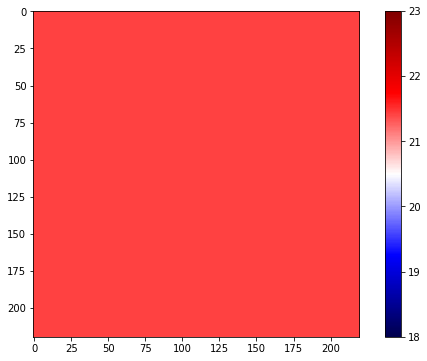

In [140]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data_upper = parameters.reshape(raw_data_test_upper.shape[0],raw_data_test_upper.shape[1],4)
# X,Y = np.meshgrid(np.linspace(1,10,final_data.shape[0]),np.linspace(1,10,final_data.shape[1]))
# fig, ax = plt.subplots()
shw = plt.imshow((final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3)),cmap='seismic',interpolation='none',vmin=18,vmax=23)
colorbar = plt.colorbar(shw)
plt.show()

In [141]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data[4,1,:]

array([-3.3037037e-02,  3.0862951e+01,  6.0152645e+01,  1.0254290e+00],
      dtype=float32)

In [151]:
final_data = parameters.reshape(raw_data_test.shape[0],raw_data_test.shape[1],4)
final_data_upper = parameters.reshape(raw_data_test_upper.shape[0],raw_data_test_upper.shape[1],4)
# X,Y = np.meshgrid(np.linspace(1,10,final_data.shape[0]),np.linspace(1,10,final_data.shape[1]))
# fig, ax = plt.subplots()
shw = plt.imshow((final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3)),cmap='seismic',interpolation='none',vmin=18,vmax=23)
colorbar = plt.colorbar(shw)
plt.show()

array([[27.762758, 26.950678, 21.683054, ..., 26.00374 , 24.200209,
        23.585075],
       [23.170492, 26.848682, 25.46356 , ..., 23.535551, 26.153233,
        24.861528],
       [22.904263, 23.44906 , 23.722155, ..., 25.838207, 25.888187,
        22.837307],
       ...,
       [24.221966, 23.82025 , 24.545692, ..., 26.230328, 25.770144,
        25.507137],
       [24.981813, 25.256699, 24.105116, ..., 25.91241 , 24.757195,
        24.062265],
       [27.364687, 27.367111, 24.02021 , ..., 24.067137, 25.352388,
        25.116043]], dtype=float32)

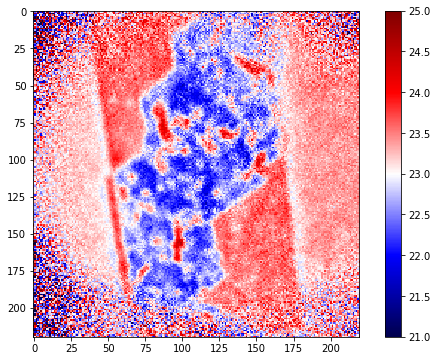

In [190]:
shw = plt.imshow((final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3)),cmap='seismic',interpolation='none',vmin=21,vmax=25)
colorbar = plt.colorbar(shw)
plt.show()

In [67]:
final_data_u pper[5,5]

array([-9.022804e-03,  2.600277e+01,  6.581340e+00,  1.008613e+00],
      dtype=float32)

In [160]:
final_data[:,:,1].shape

(220, 220)

In [ ]:
final_data[:,:,1]

In [ ]:
(final_data_upper[:,:,1]-final_data[:,:,1]+40)*0.003/(2*2.8*10**(-3))

In [ ]:
final_data_upper[:,:,1]-final_data[:,:,1]+40

In [ ]:
ratio = np.sum(states == 1) / parameters.shape[0] * 100
print(f'ratio max iterations exceeded  {ratio} %')
ratio_upper = np.sum(states == 1) / parameters_upper.shape[0] * 100
print(f'ratio_upper max iterations exceeded  {ratio_upper} %')